In [45]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as skimage
import scipy

from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse.linalg import lsqr

# note we imported the sparse least squares function  

In [46]:
# take some images with different exposure times.  
# make sure your camera (phone) does not move between exposures. I used a phone tripod.

# images
Ims = []
# exposure times
dts = []

Ims.append(plt.imread('/Users/yashp/OneDrive/Desktop/UCI Stuff/Junior/Winter/CS 116/HW 3/IMG_2894.jpg'))
dts.append(0.005)

Ims.append(plt.imread('/Users/yashp/OneDrive/Desktop/UCI Stuff/Junior/Winter/CS 116/HW 3/IMG_2895.jpg'))
dts.append(0.02)

Ims.append(plt.imread('/Users/yashp/OneDrive/Desktop/UCI Stuff/Junior/Winter/CS 116/HW 3/IMG_2898.jpg'))
dts.append(0.1)

Ims.append(plt.imread('/Users/yashp/OneDrive/Desktop/UCI Stuff/Junior/Winter/CS 116/HW 3/IMG_2897.jpg'))
dts.append(1.0)


In [47]:
# resize the images to a reasonable scale 
Imsr = []
for idx in range(len(Ims)):
    # note this will resize factor of 1/8 for each side and convert to type float
    
    # "cheap" conversion from color to gray scale by taking the mean of rgb values
    I = np.mean(Ims[idx],axis=2)
    # resize to 1/8 of each dimension
    Ir=skimage.transform.resize(I, (I.shape[0] // 8, I.shape[1] // 8), anti_aliasing=True)
    Imsr.append(Ir)
    print(f"Imsr[{idx}].shape={Imsr[idx].shape} Imsr[{idx}].dtype={Imsr[idx].dtype} ",end="")
    print(f"values from {np.min(Imsr[idx][:])} to {np.max(Imsr[idx][:])}")
    
    # convert to uint8 (forcing a value from 0..255) just to have discrete pixel values
    Imsr[idx]=Imsr[idx].astype("uint8")
    print(f"Imsr[{idx}].shape={Imsr[idx].shape} Imsr[{idx}].dtype={Imsr[idx].dtype} ",end="")
    print(f"values in {np.min(Imsr[idx][:])} .. {np.max(Imsr[idx][:])}")
    print(f"dts[{idx}]={dts[idx]}")
    

Imsr[0].shape=(378, 378) Imsr[0].dtype=float64 values from 0.0 to 53.390115578737266
Imsr[0].shape=(378, 378) Imsr[0].dtype=uint8 values in 0 .. 53
dts[0]=0.005
Imsr[1].shape=(378, 378) Imsr[1].dtype=float64 values from 0.0 to 194.26949488627437
Imsr[1].shape=(378, 378) Imsr[1].dtype=uint8 values in 0 .. 194
dts[1]=0.02
Imsr[2].shape=(378, 378) Imsr[2].dtype=float64 values from 12.815263291343918 to 250.5942364892112
Imsr[2].shape=(378, 378) Imsr[2].dtype=uint8 values in 12 .. 250
dts[2]=0.1
Imsr[3].shape=(378, 378) Imsr[3].dtype=float64 values from 13.932412441285335 to 254.90864716257929
Imsr[3].shape=(378, 378) Imsr[3].dtype=uint8 values in 13 .. 254
dts[3]=1.0


In [48]:
# simple version of optimization

# solving for entries in v
# first 256 entries are for g(0) ... g(255) then next h*w entries are for pixel brightnesses
#
# Z_ij is the pixel value at location i in image j
# dt_j is the exposure time for image j
# g(z) is the energy x that the sensor receives (exposure) to produce pixel value z
#      (the exposure is the irradiance R times exposure time)
#
#  x = R*dt
#  for pixel i in image j
#  x_ij = R_ij*dt_j
#
#  Z_ij = f(x_ij)  # the pixel value Z_ij comes from mapping the exposure through some function f
#  g() is the inverse of f()
#  
#  so if Z_ij = f(x_ij) we want g(Z_ij)=x_ij (=R_ij*dt_j)
#
#  taking logs of everything:
#
# g(Z_ij) = ln(R_i)+ln(dt_j) # pixel i,image j with time dt_j
# g(Z_ij) - ln(R_i) = ln(dt_j)
#
# making this into a constraint
#
# Each pixel i in imag j gives one row of A and one entry in b
# position: 0...... Z_ij ...255 0 1 2 ... i*w+j ... h*w
# coefficient: 0 0 ... 1.......0 0 .......... -1 ......0
#
# entry in b: ln(dt_j)
#
#  We want to solve for v so that Av=b
#  or the v that minimizes |Av-b|^2


[h,w]=Imsr[0].shape
l = len(Imsr)
# Initialize A as a lil_matrix with the appropriate size
A_rows = h * w * l + 1
# A_cols = 256 + h * w * l + 1
A_cols = 256 + h * w
A = lil_array((A_rows, A_cols))
print(A.shape)
# Initialize b as a numpy array of zeros
b = np.zeros((A_rows,))
# setup rows of A and entries in b
# Loop through each pixel in each image
# Number of images 
idx = 0
for j in range(l):
    # Number of rows in each image
    for y in range(h):
        # Number of columns in each image
        for x in range(w):
            # Calculate the index for the current pixel
            idx = j * h * w + y * w + x
            # print(f"idx: {idx}, A_cols: {A_cols}, 256 + idx: {256 + idx}, j * h * w + y * w + x: {j * h * w + y * w + x}")
            
            # Calculate the pixel value Z_ij from the resized images
            Z_ij = Imsr[j][y, x]
            
            # Add a row to A and an entry to b for the current pixel
            A[idx, Z_ij] = 1
            A[idx, 256 + y*x] = -1
            b[idx] = np.log(dts[j])
print("Final index is :", idx)
# add a constraint that "fixes" g(128) to be say 4 or such
# This is achieved by adding a row to A and an entry to b
constraint_idx = A_rows - 1  # Index for the last row (constraint row, empty)
A[constraint_idx, 128] = 1  # Constraint for fixing g(128)
A[constraint_idx, 256:] = 0  # Ensure only the g(128) constraint is added to the last row
b[constraint_idx] = 4



(571537, 143140)
Final index is : 571535


In [49]:
#solve for least squares solution
Acsr=csr_array(A)# convert a to a csrarray before calling least squares
soln = lsqr(Acsr,b,atol=1e-07, btol=1e-07)
v = soln[0]

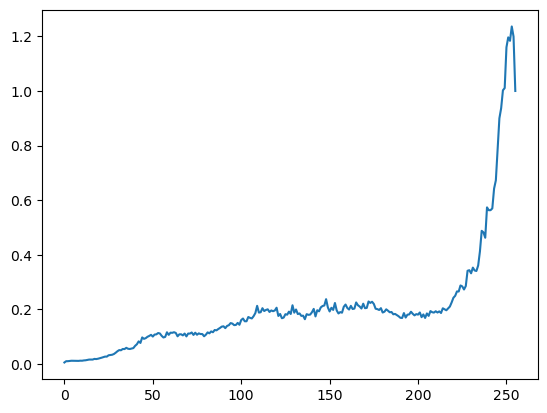

In [50]:
plt.plot(np.exp(v[0:256]))

In [93]:
# Calculate regularization weights: 
# Hardcode regularizaion_weight for now
regularization_weights = []
def calculate_regularization_weight(image, size_of_image, scaling_factor):
    # Calculate the standard deviation of pixel values in the region
    noise_level = np.std(image)
    
    # Scale the noise level to determine the regularization weight
    regularization_weight = scaling_factor * noise_level
    
    return regularization_weight

for image in Ims:
    size_of_image = (377, 377, 377, 377)
    scaling_factor = 0.1
    regularization_weights.append(calculate_regularization_weight(image, size_of_image, scaling_factor))

print(regularization_weights)

[0.5162206697523292, 4.152722714767378, 7.529810491568016, 8.329813961480818]


In [95]:
# Adding some bells and whistles to the optimization setup
#
#
# solving for entries in v
# first 256 entries are for g(0) ... g(255) then next h*w entries are for pixel brightnesses
# g(x) = ln(R_i)+ln(dt_j) # pixel i,image j with time dt_j
# g(x) - ln(R_i) = ln(dt_j)
#
# weighted version where weight depends on the pixel value (can care less about 0..5 and 250-255) 
# w(R_i)g(x) - q(R_i)ln(R_i) = w(R_i)ln(dt_j)
#
# also add regularization so that g(x) tends to be smooth
#
# l(g(i+1)-g(i)) - l(g(i)-g(i-1)) = 0
# lg(i)-2g(i+1)-g(i+2) = 0
#
# where l is some weight on this constraint
#
# remember to add a constraint that "fixes" g(128) to be say 4 or such

# Initialize A as a lil_matrix with the appropriate size
A_rows = h * w * l + 1
A_cols = 256 + h * w
A = lil_array((A_rows, A_cols))
print(A.shape)

# Initialize b as a numpy array of zeros
b = np.zeros((A_rows,))

def weight_function(value_of_pixel):
    if value_of_pixel < 5 or value_of_pixel > 250:
        return 0.1  # Assign a low weight to pixel values less than 5 or greater than 250
    elif 5 <= value_of_pixel <= 250:
        return 1.0  # Assign a higher weight to pixel values between 5 and 250
    else:
        return 0.5  # Default weight for other pixel values

# Loop through each pixel in each image
for j in range(l):
    for y in range(h):
        for x in range(w):
            # Calculate the index for the current pixel
            idx = j * h * w + y * w + x
            # print(f"idx: {idx}, A_cols: {A_cols}, 256 + idx: {256 + idx}, j * h * w + y * w + x: {j * h * w + y * w + x}")
            
            # Calculate the pixel value Z_ij from the resized images
            Z_ij = Imsr[j][y, x]
            
            # Add a row to A and an entry to b for the current pixel
            A[idx, Z_ij] = weight_function(Z_ij)  # Apply weight based on pixel value
            
            # Regularization term for g(i) - 2g(i+1) + g(i+2)
            if x < w - 2:
                reg_weight = regularization_weights[j]
                A[idx, 256 + y * w + x] = reg_weight
                A[idx, 256 + y * w + x + 1] = -2 * reg_weight
                # lsqr calculation extremely slow with this for some reason
                # A[idx, 256 + y * w + x + 2] = reg_weight
            b[idx] = weight_function(Z_ij) * np.log(dts[j])  # Apply weight to b based on pixel value

# Add a constraint that "fixes" g(128) to be 4 or such
constraint_idx = A_rows - 1  # Index for the last row (constraint row)
A[constraint_idx, 128] = 1  # Constraint for fixing g(128)
A[constraint_idx, 256:] = 0  # Ensure only the g(128) constraint is added to the last row
b[constraint_idx] = 4 # fixed_value_for_g_128

(571537, 143140)


In [96]:
Acsr=csr_array(A)
soln = lsqr(Acsr,b,atol=1e-07, btol=1e-07)
v=soln[0]

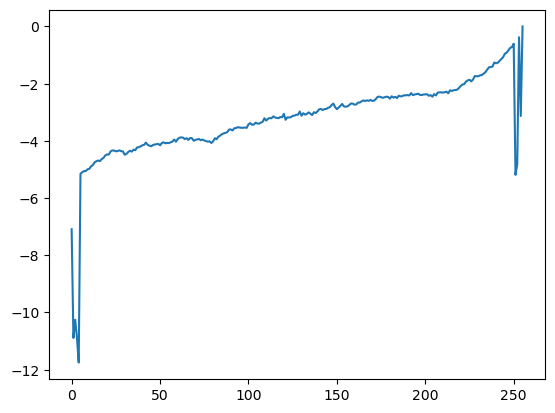

In [88]:
plt.plot(v[0:256]) # note plotting g(z) here not exp(g(z))

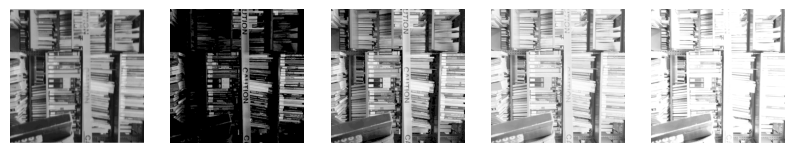

In [97]:
f=plt.figure()
f.set_size_inches(10, 6)
ax = f.add_subplot(1,5,1)
ax.imshow(np.fliplr(np.transpose(np.reshape(v[256:],(h,w)))),cmap="gray")
ax.axis("off")
for i in range(len(Imsr)):
    ax = f.add_subplot(1,5,i+2)
    ax.imshow(np.fliplr(np.transpose(np.log(Imsr[i]+1))),cmap="gray")
    ax.axis("off")


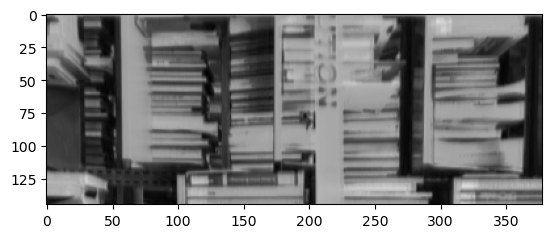

In [98]:
da_Im=np.fliplr(np.transpose(np.reshape(soln[0][256:],(h,w))))
plt.imshow(da_Im[0:145,:],cmap="gray")


C:\Users\yashp\AppData\Local\Temp\ipykernel_17796\2275842349.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.flipud(np.log(Imsr[0][:,145])),color='r')
C:\Users\yashp\AppData\Local\Temp\ipykernel_17796\2275842349.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.flipud(np.log(Imsr[1][:,145])),color='g')


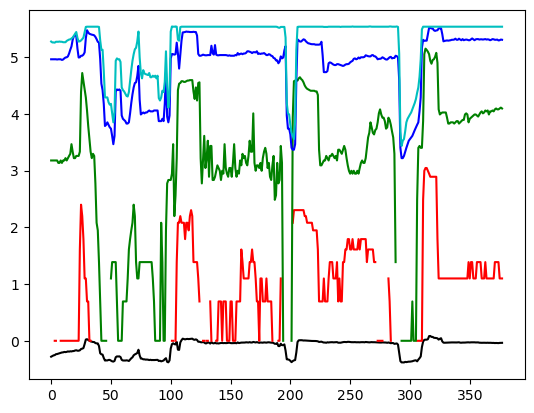

In [99]:
# show one horixontal line (bottom of image above) in each exposure and the high  dynamic range image
# note that the hdr image has detail in both the darker and the lighter areas whereas the individual
# exposures lack detail in one (e.g. no dark detail in red) or the other (no light detail in cyan)
plt.plot(da_Im[145,:],'k')
plt.plot(np.flipud(np.log(Imsr[0][:,145])),color='r')
plt.plot(np.flipud(np.log(Imsr[1][:,145])),color='g')
plt.plot(np.flipud(np.log(Imsr[2][:,145])),color='b')
plt.plot(np.flipud(np.log(Imsr[3][:,145])),color='c')
# plotted logs to make it easier to see variations